In [11]:
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import os
from transform_factory import tensorize, center_crop_224, resize_322, imagenet_normalize
from PIL import Image
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [12]:
# config
seed = 0
data_num = 97
# expl_method = "GradCAM"
expl_method = "LayerXAct"

In [13]:
model = resnet50(weights=ResNet50_Weights.DEFAULT).eval()

In [14]:
with open(f"./val_seed_{seed}.npy", "rb") as f:
    filepath_list = np.load(f)

orig_imgs = []
orig_expls = []


for img_path in filepath_list[:data_num]:
    img_name = os.path.basename(img_path)

    orig_img = Image.open(img_path)
    orig_img = imagenet_normalize(tensorize(center_crop_224(resize_322(orig_img))))

    orig_imgs.append(orig_img)

    with open(f"results/val_seed_{seed}_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img_name}_expl_{expl_method}_sample_2000_sigma_0.05_seed_{seed}_orig_true_config.npy", "rb") as f:
        orig_expl = np.load(f, allow_pickle=True)
        true_expls = np.load(f, allow_pickle=True)
        configs = np.load(f, allow_pickle=True)

        orig_expl = F.interpolate(torch.tensor(orig_expl).unsqueeze(0), (224, 224), mode='bilinear').squeeze(0).numpy()

        orig_expls.append(orig_expl)


orig_imgs = torch.stack(orig_imgs)
orig_expls = torch.tensor(np.stack(orig_expls))


In [15]:
orig_imgs.shape
orig_expls.shape

torch.Size([97, 1, 224, 224])

In [16]:
y = model(orig_imgs).argmax(dim = 1)

In [17]:
class AOPCTestor():
    def __init__(self, model) -> None:
        self.model = model
        self.softmax = torch.nn.Softmax(dim = 1)


    @staticmethod
    def perturbation(expl, img, ratio, mode="insertion"):
    # expl : [B, C=1, H, W]
    # img : [B, C=3, H, W]
        order = expl.flatten(1).argsort(descending=True)
        n_perturb = int(ratio * order.shape[1])
        n_order = order[:, n_perturb] 
        threshold = expl.flatten(1)[range(len(expl)), n_order]

        if mode == "insertion":
            mask = expl > threshold.reshape(len(expl), 1, 1).unsqueeze(1)
        elif mode == "deletion":
            mask = expl < threshold.reshape(len(expl), 1, 1).unsqueeze(1)        
        return (img * mask).detach()

    @staticmethod
    def conf_perturbation(expl, img, ratio, conf_high, conf_low, mode="insertion"):
        attr_order = expl.flatten(1).argsort(descending = True)
        

    def test_step(self, expl, img, label, mode="orig"):
        prob_list = []
        for ratio in np.arange(0, 1, 0.05):

            # if mode == "orig":
            img_p = self.perturbation(expl, img, ratio=ratio, mode=mode)
            # else:
                # img_p = self.conf_perturbation(expl, img, ratio=ratio)

            logit = self.model(img_p)
            prob = self.softmax(logit)

            aopc_prob = prob[range(len(label)), label].detach().mean()
            prob_list.append(aopc_prob)

        return prob_list

In [18]:
tester = AOPCTestor(model=model)
prob_list = tester.test_step(orig_expls, orig_imgs, y, mode="insertion")

In [19]:
prob_list_del = tester.test_step(orig_expls, orig_imgs, y, mode="deletion")

In [20]:
print(prob_list, torch.stack(prob_list).mean())

[tensor(0.0011), tensor(0.0880), tensor(0.2419), tensor(0.4229), tensor(0.5270), tensor(0.6469), tensor(0.7216), tensor(0.7616), tensor(0.8128), tensor(0.8561), tensor(0.8921), tensor(0.9077), tensor(0.9200), tensor(0.9318), tensor(0.9439), tensor(0.9502), tensor(0.9573), tensor(0.9607), tensor(0.9616), tensor(0.9645)] tensor(0.7235)


In [21]:
print(prob_list_del, torch.stack(prob_list_del).mean())

[tensor(0.9643), tensor(0.9186), tensor(0.8416), tensor(0.7603), tensor(0.6799), tensor(0.5586), tensor(0.4714), tensor(0.3889), tensor(0.2929), tensor(0.2395), tensor(0.1945), tensor(0.1439), tensor(0.1048), tensor(0.0786), tensor(0.0597), tensor(0.0369), tensor(0.0223), tensor(0.0113), tensor(0.0077), tensor(0.0041)] tensor(0.3390)


In [35]:
conf_highs = []
conf_lows = []

alpha = 0.05

for img_path in filepath_list[:data_num]:
    img_name = os.path.basename(img_path)
    
    with open(f"results/val_seed_{seed}_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img_name}_expl_{expl_method}_sample_2000_sigma_0.05_seed_{seed}_results.pkl", "rb") as f:
        results = np.load(f, allow_pickle=True)

    result = results[0]

    conf_highs.append(torch.tensor(result['conf_high']))
    conf_lows.append(torch.tensor(result['conf_low']))


conf_highs = torch.stack(conf_highs)
conf_lows = torch.stack(conf_lows)

/tmp/ipykernel_1106847/1297997061.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conf_highs.append(torch.tensor(result['conf_high']))
/tmp/ipykernel_1106847/1297997061.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conf_lows.append(torch.tensor(result['conf_low']))


FileNotFoundError: [Errno 2] No such file or directory: 'results/orig_224_true_322_sigma_0.5_rot_360/val_seed_0_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/ILSVRC2012_val_00011627.JPEG_expl_LayerXAct_sample_2000_sigma_0.05_seed_0_results.pkl'

In [29]:
tester = AOPCTestor(model=model)
# tester.test_step(conf_lows, orig_imgs, y, mode='deletion')
high_prob_list = tester.test_step(conf_highs, orig_imgs, y, mode='deletion')


In [30]:
print(high_prob_list, torch.stack(high_prob_list).mean())


[tensor(0.9648), tensor(0.9085), tensor(0.8319), tensor(0.7373), tensor(0.6308), tensor(0.5482), tensor(0.4697), tensor(0.3769), tensor(0.3068), tensor(0.2512), tensor(0.1806), tensor(0.1356), tensor(0.1054), tensor(0.0690), tensor(0.0444), tensor(0.0252), tensor(0.0167), tensor(0.0106), tensor(0.0059), tensor(0.0022)] tensor(0.3311)


In [33]:
low_prob_list = tester.test_step(conf_highs, orig_imgs, y, mode='insertion')


In [32]:
print(low_prob_list, torch.stack(low_prob_list).mean())


[tensor(0.0011), tensor(0.1095), tensor(0.2437), tensor(0.3492), tensor(0.4465), tensor(0.5186), tensor(0.6169), tensor(0.7087), tensor(0.7593), tensor(0.8118), tensor(0.8291), tensor(0.8635), tensor(0.8822), tensor(0.8901), tensor(0.9037), tensor(0.9197), tensor(0.9315), tensor(0.9291), tensor(0.9449), tensor(0.9572)] tensor(0.6808)


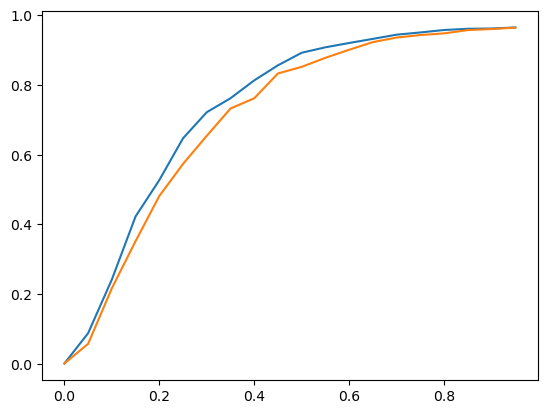

In [34]:
plt.plot(np.arange(0, 1, 0.05), prob_list)
plt.plot(np.arange(0, 1, 0.05), low_prob_list)


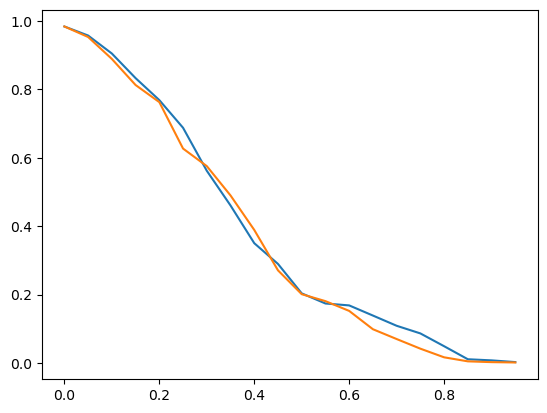

In [40]:
plt.plot(np.arange(0, 1, 0.05), prob_list_del)
plt.plot(np.arange(0, 1, 0.05), high_prob_list)